## Recommender Engine: Probabilistic Matrix Factorization
https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/probabilistic_matrix_factorization.html

In [ ]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib import pyplot as plt

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

In [21]:
import logging
import time

import scipy as sp
import theano

# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model() as pmf:
            U = pm.MvNormal(
                "U",
                mu=0,
                tau=self.alpha_u * np.eye(dim),
                shape=(n, dim),
                testval=np.random.randn(n, dim) * std,
            )
            V = pm.MvNormal(
                "V",
                mu=0,
                tau=self.alpha_v * np.eye(dim),
                shape=(m, dim),
                testval=np.random.randn(m, dim) * std,
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

/Users/angie/opt/anaconda3/lib/python3.9/site-packages/theano/scalar/basic.py:2323: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.ctor = getattr(np, o_type.dtype)


In [22]:
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        self._map = pm.find_MAP(method="L-BFGS-B")

    elapsed = int(time.time() - tstart)
    logging.info("found PMF MAP in %d seconds" % elapsed)
    return self._map


def _map(self):
    try:
        return self._map
    except:
        return self.find_map()


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)

In [23]:
# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    kwargs.setdefault("chains", 1)
    with self.model:
        self.trace = pm.sample(**kwargs)


# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

In [24]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

In [25]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE

In [26]:
n, m = dense_data.shape  # # users, # movies
N = n * m  # # cells in matrix
train = dense_data.copy()
test = np.ones(dense_data.shape) * np.nan

    # Draw random sample of training data to use for testing.
tosample = np.where(~np.isnan(train))  # ignore nan values in data
idx_pairs = list(zip(tosample[0], tosample[1]))  # tuples of row/col index pairs

test_size = int(len(idx_pairs) * .1)  # use 10% of data as test set
train_size = len(idx_pairs) - test_size  # and remainder for training


indices = np.arange(len(idx_pairs))  # indices of index pairs
sample = np.random.choice(indices, replace=False, size=test_size)

In [27]:
    # Transfer random sample from train set to test set.
for idx in range(len(sample)):
    idx_pair = idx_pairs[idx]
    test[idx_pair] = train[idx_pair]  # transfer to test set
    train[idx_pair] = np.nan  # remove from train set

# Verify everything worked properly
assert train_size == N - train.isnan.sum()
assert test_size == N - test.isnan.sum()

# Return train set and test set
return train, test


train, test = split_train_test(dense_data)

KeyError: (9, 8160)

In [43]:
dense_data

,005lwxGU1tms6HGELIcUv9,00CqEmnPLFKDhAb3cuu6Cs,00L9IGHexZLnscZiQpUWTG,00Mb3DuaIH1kjrwOku9CGU,00S66PHVusji3COAuNUpLP,00WubJUWuC6V8PKvqaHmQ2,00bd2zIw68UZUvtVdR9Zh3,00kbBKPcMWN7636XbdhhWu,00s2jnZ4cVZssim4VqrszP,00uaBUnmyGxBUSwG37sWHx,...,7zWwTeVvMM6juC1Kru1pu3,7za1TCWFFPF9ZSUZutkds5,7zbX1txfcs42K2PlhFJNNE,7ze7yEV1xvxPxuPaF0oUUU,7zfmhBiUvGoHz76NO1d5bZ,7zhzzFiASS8lOHLrooBI1t,7znoroIV2dSMcjpv7ZxnLh,7zqM7Wm2xJLZ50qAnTLoHD,7zsXy7vlHdItvUSH8EwQss,7zy1cb4QkODyjddpmTw7Nm
user_id,,,,,,,,,,,,,,,,,,,,,
19735,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25372,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30816,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36482,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
49203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print("{} RMSE:\t{:.5f}".format(method, baselines[name]))

In [ ]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 10


pmf = PMF(train, DIM, ALPHA, std=0.05)

In [ ]:
# Find MAP for PMF.
pmf.find_map();

In [ ]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print("PMF MAP training RMSE: %.5f" % train_rmse)
    print("PMF MAP testing RMSE:  %.5f" % test_rmse)
    print("Train/test difference: %.5f" % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [ ]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_rmse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)

In [ ]:
# Draw MCMC samples.
pmf.draw_samples(
    draws=500,
    tune=500,
)

In [ ]:
def _norms(pmf_model, monitor=("U", "V"), ord="fro"):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ("U", "V")
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms["U"])
    v_series = pd.Series(trace_norms["V"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind="line", ax=ax1, grid=False, title=r"$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind="line", ax=ax2, grid=False, title=r"$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")


PMF.norms = _norms
PMF.traceplot = _traceplot

In [ ]:
pmf.traceplot()

In [ ]:
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence."""
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {"per-step-train": [], "running-train": [], "per-step-test": [], "running-test": []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample["U"], sample["V"])
        R += sample_R
        running_R = R / (cnt + 1)
        results["per-step-train"].append(rmse(train_data, sample_R))
        results["running-train"].append(rmse(train_data, running_R))
        results["per-step-test"].append(rmse(test_data, sample_R))
        results["running-test"].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind="line",
            grid=False,
            figsize=(15, 7),
            title="Per-step and Running RMSE From Posterior Predictive",
        )

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

In [ ]:
predicted, results = pmf.running_rmse(test, train)

In [ ]:
# And our final RMSE?
final_test_rmse = results["running-test"].values[-1]
final_train_rmse = results["running-train"].values[-1]
print("Posterior predictive train RMSE: %.5f" % final_train_rmse)
print("Posterior predictive test RMSE:  %.5f" % final_test_rmse)
print("Train/test difference:           %.5f" % (final_test_rmse - final_train_rmse))
print("Improvement from MAP:            %.5f" % (pmf_map_rmse - final_test_rmse))
print("Improvement from Mean of Means:  %.5f" % (baselines["mom"] - final_test_rmse))

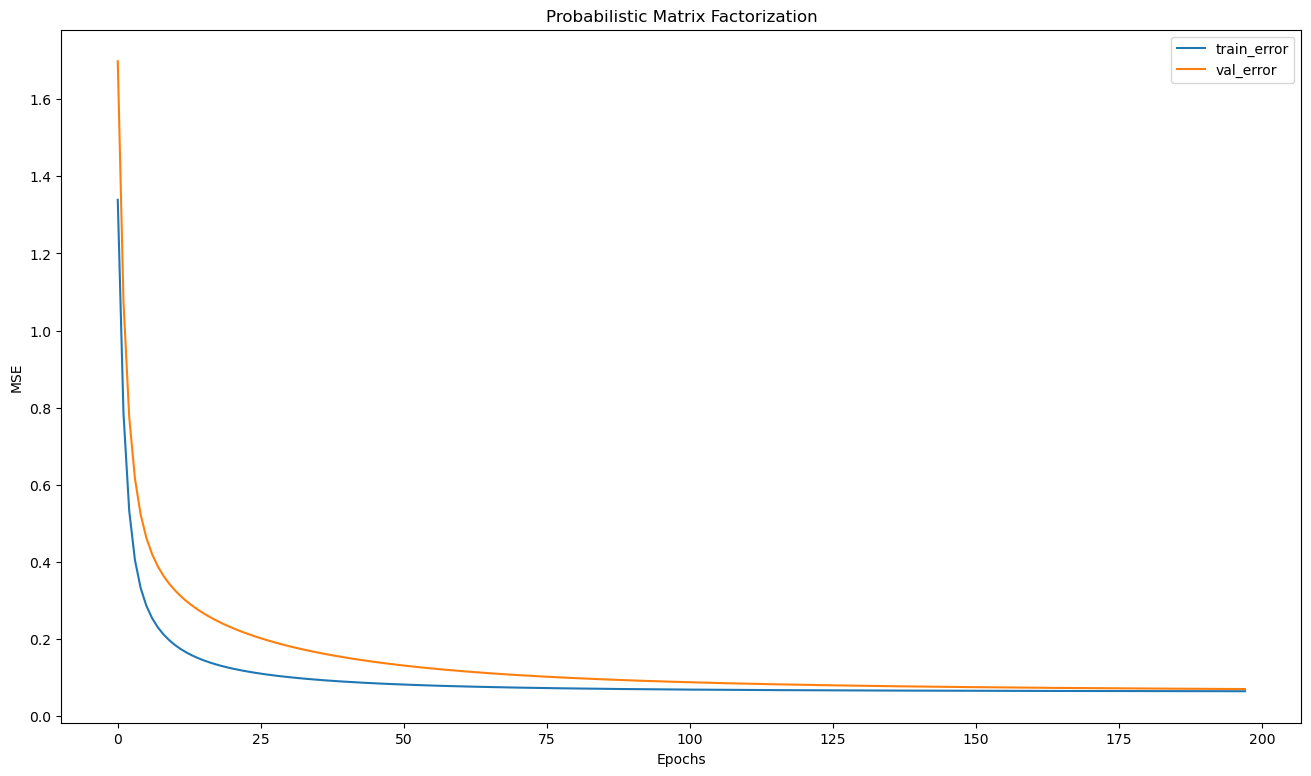

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(recommender.train_error[2:], label = "train_error")
ax.plot(recommender.val_error[2:], label = "val_error")
ax.set_title("Probabilistic Matrix Factorization")
ax.set_ylabel("MSE")
ax.set_xlabel("Epochs")
ax.legend();

# Topic Modeling with LDA

In [19]:
nlp = spacy.load("en_core_web_sm")

songs.loc[:,"lemmas"] = [[[token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() 
                     for token in sentence if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"}]
                    for sentence in nlp(speech).sents] for speech in songs.description]


/var/folders/10/1c86lclx5jl02jg4c_tsyy_c0000gn/T/ipykernel_14381/2254759377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs["lemmas"] = [[[token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower()


In [20]:
instances = [[lemma for lemmatized_sentence in lemmatized_speech for lemma in lemmatized_sentence]
             for lemmatized_speech in songs.lemmas]

dictionary = Dictionary(instances)

dictionary.filter_extremes(no_below = 5, no_above = 0.8)
print(dictionary)

Dictionary(845 unique tokens: ['alternative', 'chill', 'horse', 'indie', 'midtempo']...)


In [21]:
random.seed(10)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]


num_topics = 15
num_passes = 30
chunk_size = len(model_corpus) * num_passes/200

model = LdaMulticore(num_topics=num_topics,
                    corpus=model_corpus,
                    id2word=dictionary,
                    workers=multiprocessing.cpu_count()-1,
                    chunksize=chunk_size,
                    passes=num_passes,
                    alpha=0.1)

In [22]:
all_topics = model.get_document_topics(model_corpus, per_word_topics=True, minimum_probability=0.0)

corpus_topics = []

for doc_topics, word_topics, phi_values in all_topics:
    corpus_topics.append([topic[1] for topic in doc_topics])
    
corpus_topics = np.array(corpus_topics)

In [23]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, model_corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(LDAvis_prepared, 'lda.html')
LDAvis_prepared

/Users/angie/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/angie/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/angie/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/angie/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/angie/opt/anaconda3/lib/python3.9/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.116228  0.019190       1        1   5.794779
1      0.167936 -0.029534       2        1  10.829534
2      0.190282 -0.018821       3        1   7.521287
3     -0.198276 -0.036994       4        1   6.498229
4     -0.140281  0.059962       5        1   5.618085
5     -0.020266  0.291599       6        1   7.843389
6      0.122258 -0.083281       7        1   5.286558
7      0.060398  0.044072       8        1   4.580656
8      0.124094  0.028309       9        1   8.408466
9     -0.103158 -0.064002      10        1   6.595837
10    -0.092480 -0.079438      11        1   6.023129
11     0.067501 -0.011406      12        1   7.307209
12    -0.159296 -0.073660      13        1   5.534084
13    -0.043723 -0.018102      14        1   5.295096
14     0.141236 -0.027894      15        1   6.863661, topic_info=            Term        Freq       Total Category  logprob  loglift
652      country  204.000000  204.000000  Default  30.0000  30.0000
14           hip  329.000000  329.000000  Default  29.0000  29.0000
45     lowenergy  364.000000  364.000000  Default  28.0000  28.0000
116         rock  358.000000  358.000000  Default  27.0000  27.0000
8             rb  328.000000  328.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
13         happy   15.750101  337.826327  Topic15  -4.4108  -0.3868
18           rap   15.480383  315.030445  Topic15  -4.4281  -0.3342
4       midtempo   14.710063  230.399569  Topic15  -4.4791  -0.0724
29         major   14.875974  276.539752  Topic15  -4.4679  -0.2437
50   nonacoustic   13.370831  342.533228  Topic15  -4.5746  -0.5644

[840 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
438       2  0.844294       aap
53        1  0.055298  acoustic
53        2  0.110596  acoustic
53        3  0.031599  acoustic
53        4  0.078997  acoustic
...     ...       ...       ...
520       3  0.605064      year
99        1  0.047214     young
99        8  0.849851     young
99       15  0.094428     young
631       6  0.980244         z

[1372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [32]:
#Some of the words that describe the topic
words = [model.print_topics(num_topics=num_topics, num_words=10)[topic][1].split('\"')[1::2] for topic in range(num_topics)]

words_per_topic = dict(zip(range(num_topics), words))

words_per_topic

{0: ['country',
  'dawn',
  'thrash',
  'road',
  'metal',
  'old',
  'school',
  'hard',
  'carrie',
  'rock'],
 1: ['rb',
  'contemporary',
  'soul',
  'urban',
  'indie',
  'pop',
  'alternative',
  'new',
  'midenergy',
  'rap'],
 2: ['hip',
  'rap',
  'hop',
  'someinstrumental',
  'conscious',
  'underground',
  'midenergy',
  'new',
  'minor',
  'hightempo'],
 3: ['rock',
  'folk',
  'classic',
  'gold',
  'stomp',
  'mellow',
  'holler',
  'album',
  'baby',
  'singersongwriter'],
 4: ['bad',
  'hollywood',
  'black',
  'angel',
  'rock',
  'tune',
  'nondanceable',
  'lowenergy',
  'king',
  'poptimism'],
 5: ['lowenergy',
  'nondanceable',
  'minor',
  'nonacoustic',
  'sad',
  'popularitylow',
  'z',
  'alt',
  'banda',
  'acoustic'],
 6: ['girl',
  'pop',
  'rap',
  'hip',
  'ninety',
  'bedroom',
  'mende',
  'shawn',
  'grupera',
  'happy'],
 7: ['melodic',
  'post',
  'fall',
  'life',
  'winehouse',
  'young',
  'british',
  'rap',
  'blood',
  'never'],
 8: ['happy',
 

In [24]:
# REMOVE THE LATENT VECTOR OF THE HELDOUT SONG
theta = corpus_topics.copy().T

thet = pd.DataFrame(theta)
heldout_topics = thet.iloc[:, heldout_idx]
thet.drop(heldout_idx, axis = 1, inplace=True)
theta = thet.values

# Collaborative Topic Modeling

In [25]:
X_train = train.copy()
X_val = val.copy()

In [26]:
class CTM():
    """
    Collaborative Topic Modeling Model as developed by Wang and Blei (2012).
    Leverages topic proportions obtained from LDA model to improve predictions
    and allow for out-of-matrix predictions.
    
    Parameters:
        - sigma2: expected variance of ratings 
                  (variance of the ratings Normal prior)
        - sigma2_P: expected variance of the elements of the
                    preference vector
        - sigma2_Q: expected variance of the elements of the
                    quality vector
    """
    def __init__(self, epochs=200, learning_rate=0.001, sigma2=10, sigma2_P=10, sigma2_Q=10):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.sigma2 = sigma2
        self.sigma2_P = sigma2_P
        self.sigma2_Q = sigma2_Q
    
    
    def fit(self, theta, X_train, X_val):
        """
        Fit a CTM model.
        
        Parameters:
            - theta: (K X I) matrix of topic proportions obtained via LDA.
            - X_train: (U X I) ratings matrix to train the model on.
            - X_test: (U X I) ratings matrix to validate the model on.
        """
        
        K = theta.shape[0]
        U, I = X_train.shape
        
        #initialize P and Q matrices.
        # P is initialized randomly
        self.P = np.random.randint(0, 10) * np.random.rand(K, U)
        # Q is initialized to be equal to theta
        self.Q = theta.copy()
        
        self.train_error = []
        self.val_error = []
        
        # obtain the pairs of (u, i) indices for which we observe a rating
        users, items = X_train.nonzero()
        
        
        # begin training
        for iteration in trange(self.epochs, file=sys.stdout, desc='CTM'):
            for u, i in zip(users, items):
                error = X_train[u, i] - np.dot(self.P[:, u].T, self.Q[:, i])

                # maximizing the likelihood via gradient ascent
                self.P[:, u] += self.learning_rate * (-self.P[:, u]/self.sigma2_P + (self.P[:, u] * error) * self.sigma2)
                self.Q[:, i] += self.learning_rate * (-(self.Q[:, i] - theta[:, i])/self.sigma2_Q + (self.Q[:, i] * error) * self.sigma2)

            self.train_error.append(mse(np.dot(self.P.T, self.Q), X_train))
            self.val_error.append(mse(np.dot(self.P.T, self.Q), X_val))
    
    
    
    def predict_ratings(self):
        """
        Returns the matrix of predicted ratings.
        """
        return np.dot(self.P.T, self.Q)
    
    
    
    def predict_out_of_matrix(self, topics):
        """
        Returns the (U X 1) vector of predicted ratings 
        for an unrated item, using the item's topic proportions.
        
        Parameters:
            - topics: (K X 1) array of topic proportions
                      for the unrated item.
        """
        return np.dot(self.P.T, topics)

In [27]:
ctm = CTM(epochs=200, sigma2_P=5, sigma2_Q=5, sigma2=1)
ctm.fit(theta, X_train, X_val)

print(f"""Training done. 
        Train error: {ctm.train_error[-1]}
        Validation error: {ctm.val_error[-1]}""")

CTM: 100%|██████████| 200/200 [00:25<00:00,  7.90it/s]
Training done. 
        Train error: 0.07195293017303532
        Validation error: 0.08650341458413233


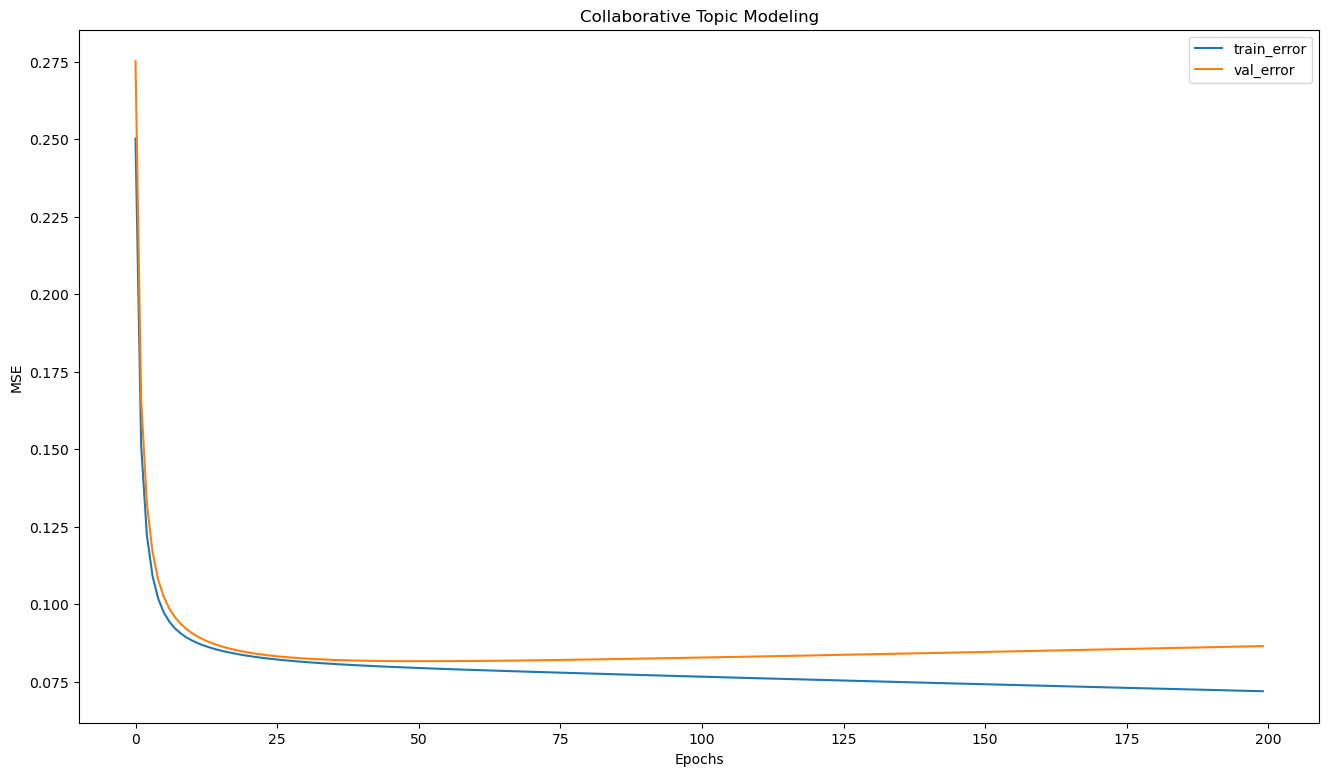

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(ctm.train_error, label = "train_error")
ax.plot(ctm.val_error, label = "val_error")
ax.set_title("Collaborative Topic Modeling")
ax.set_ylabel("MSE")
ax.set_xlabel("Epochs")
ax.legend();

In [29]:
# out-of-matrix prediction

heldout_predicted = np.dot(ctm.P.T, heldout_topics.values)

print(f"MSE for the heldout game - {heldout_name}:")
print(mse(heldout_predicted, heldout_ratings.values))

MSE for the heldout game - ("you dont know (feat. wale)", tank):
0.0004080355389703186


### Posterior Distribution for song heldout song on Topics

Topic relevances for ("you dont know (feat. wale)", tank) :


Text(0.5, 0, 'Proportion')

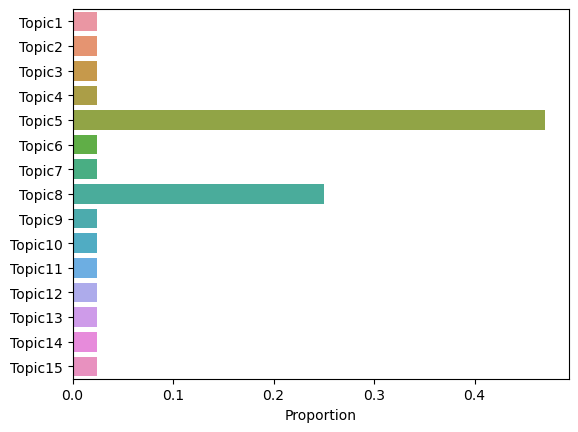

In [33]:
songname = '("you dont know (feat. wale)", tank) '

# find the index number of song
for idx, t in enumerate(R.columns):
    if songname in t:
        idx = i
        break
        
print(f"Topic relevances for {songname}:")   
k=[]
for i, mixture in enumerate(ctm.Q[:, idx]):
    k.append([round(mixture * 100, 2), words_per_topic[i]])
vals=[]
words=[]
for i in range(len(k)):
    vals.append(k[i][0])
    words.append(k[i][1])
topics=['Topic1','Topic2','Topic3','Topic4','Topic5','Topic6','Topic7','Topic8','Topic9','Topic10','Topic11','Topic12','Topic13','Topic14','Topic15']
import seaborn
seaborn.barplot(x= [x/ 100 for x in vals],y=topics)
plt.xlabel('Proportion')

In [34]:
#Predicted rating of unknown item for each user 1:11
ctm.predict_out_of_matrix([x/ 100 for x in vals])

array([0.35184428, 1.17686787, 0.85380097, 0.49178206, 0.82411242,
       0.51971509, 0.99358013, 1.00361722, 0.8183557 , 0.82079057,
       0.42350925])

In [73]:
# Top ten rankings for user 0
rankings=pd.DataFrame(ctm.predict_ratings(),columns=R.columns)
rankings.index=list(np.unique(ratings.UserID))
user0=rankings.iloc[0,:]
user0.reset_index()
user0.columns=['track','rating']
recomends=user0.sort_values(ascending=False)[0:10].reset_index()
recomends.columns=['track','rating']
recomends

,track,rating
0,(a sky like i\ve never seen (from the amazon o...,1.572039
1,"(sita ram, alice coltrane)",1.552400
2,"(tried and true, ween)",1.544628
3,"(jupiter, gallant)",1.535673
4,"(white water - bonus track, angel olsen)",1.528718
5,"(jupiter, jenny hval)",1.526376
6,"(tripasia, cloonee)",1.523265
7,"(royal and desire, animal collective)",1.517512
8,"(trop beau, lomepal)",1.512514
9,"(tres notas para decir te quiero, vicente amigo)",1.512275


# Further investigation - which genres are most popular?

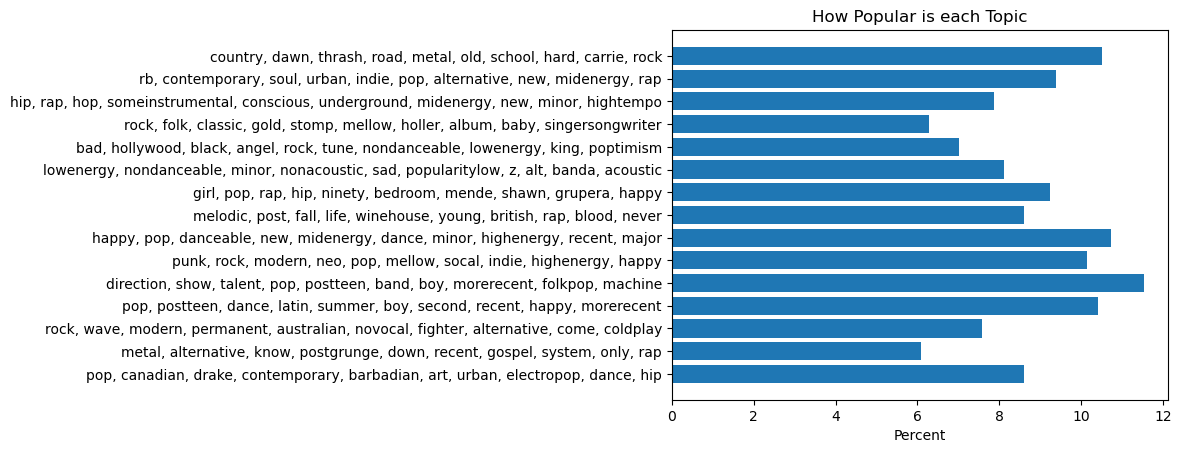

In [74]:
fig, ax = plt.subplots()

# Example data
labels = list(words_per_topic.values())
performance = ctm.P.sum(axis=1)

ax.barh([", ".join(l) for l in labels], performance, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent')
ax.set_title('How Popular is each Topic')

plt.show()

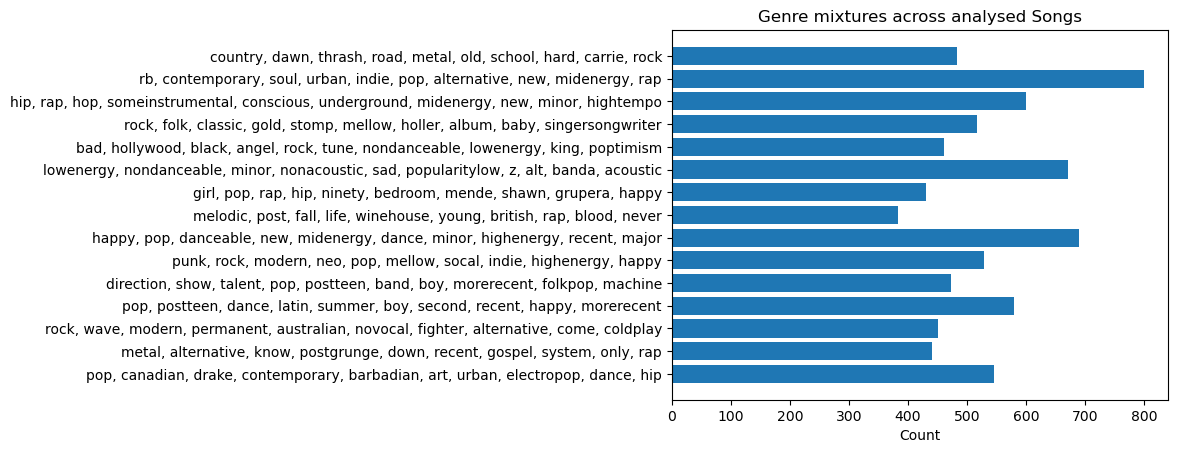

In [35]:
fig, ax = plt.subplots()

# Example data
labels = list(words_per_topic.values())
performance = ctm.Q.sum(axis=1)

ax.barh([", ".join(l) for l in labels], performance, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Genre mixtures across analysed Songs')

plt.show()